In [1]:
import scanpy as sc
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

sc.set_figure_params(figsize=(5, 5))

In [2]:
gene_sets = {
    "C-type Lectins": (
        """
        CLEC7A 
        CLEC1A
        CLEC14A
        CLEC4E
        CLEC6A 
        CLEC4C 
        CLEC5A
        CD209 
        CLEC4A
        CLEC12A
        CLEC9A
        CLEC12B
        OPRL1 
        CLEC3B
        CLEC4A 
        CLEC2D
        KLRB1 
        MRC1
        KLRD1
        WDFY4
        """
    ).split(),
    "TLRs": (
        """
        TLR1
        TLR2
        TLR3
        TLR4
        TLR5
        TLR6
        TLR7
        TLR8
        TLR10
        """
    ).split(),
    "Intracellulaar PRR": (
        """
        STING1
        CGAS
        ADA
        DDX58
        NOD1
        NOD2
        NLRP3
        NLRC4
        NLRP1
        """
    ).split(),
    "Downstream": (
        """
        TICAM1
        TICAM2
        AGER
        NFATC1
        NFATC2
        NFATC3
        NFATC4
        NFAT5
        TIRAP
        MYD88
        IRAK4
        IRAK1
        TRAF3
        TRAF6
        IKBKE
        IKBKB
        MAP3K7
        IRF7
        NFKB1
        NFKB2
        RIPK2
        ICE1
        IFIH1
        IRF3
        DHX58
        NWD1
        """
    ).split(),
    "Downstream Cytokines/ILs": (
        """
        CCL2
        CCL5
        CCL7
        CXCL8
        CXCL10
        CXCR6
        IL6
        IL12B
        IL23R
        IL17RA
        IL1B
        IL18
        IFNG
        IL2
        PLD3
        PLD4
        IL5
        IL10
        """
    ).split(),
}

In [3]:
adata = sc.read_h5ad("../../data/60_infercnv/all-annotated-integrated.h5ad")

In [4]:
adata.obs["condition"].unique()

['LUAD', 'LSCC', 'healthy_control', 'COPD', 'NSCLC']
Categories (5, object): ['LUAD', 'LSCC', 'healthy_control', 'COPD', 'NSCLC']

In [5]:
adata.obs["disease_state"] = "other"
adata.obs.loc[
    adata.obs["condition"] == "healthy_control", "disease_state"
] = "healthy_control"
adata.obs.loc[
    adata.obs["origin"].isin(["tumor_primary", "tumor_metastasis"]), "disease_state"
] = "tumor"
adata.obs.loc[adata.obs["condition"] == "COPD", "disease_state"] = "COPD"

In [6]:
adata.obs["disease_state"].value_counts()

healthy_control    249679
other              117082
tumor              115509
COPD                69064
Name: disease_state, dtype: int64

In [7]:
adata = adata[(adata.obs["disease_state"] != "other"), :]

In [8]:
# Cell-types of interest
cell_types_coarse = {
    "Alevolar": ["Alevolar cell type 1", "Alevolar cell type 2"],
    "B cell": True,
    "cDC1": True,
    "Ciliated": True,
    "DC mature": True,
    "Endothelial cell": True,
    "Endothelial cell lymphatic": True,
    "Epithelial cell": [
        "Epithelial cell dividing",
        "Epithelial cell other (benign)",
        "Club/Goblet",
    ],
    "Alevolar cell": ["Alevolar cell type 1", "Alevolar cell type 2"],
    "Fibroblast": ["Fibroblast adventitial", "Fibroblast", "Fibroblast alevolar"],
    "stromal (non-Fibroblast)": [
        "Smooth muscle cell",
        "Pericyte",
        "Mesothelial",
        "stromal other",
    ],
    "Monocyte": ["Monocyte non-conventional", "Monocyte conventional"],
    "Macrophage": ["Macrophage", "Macrophage alevolar"],
    "Plasma cell": True,
    "Mast cell": ["other"],
    "myeloid (other)": ["other myeloid assoc.", "myeloid other", "cDC2"],
    "T cell": ["T cell CD8", "T cell CD4", "T cell dividing", "T reg"],
    "NK cell": True,
    "Epithelial cell (malignant)": True,
}

In [9]:
adata.obs["cell_type_coarse"] = "other"
for new_label, cell_types in cell_types_coarse.items():
    if cell_types is True:
        cell_types = [new_label]
    for tmp_cell_type in cell_types:
        mask = adata.obs["cell_type"] == tmp_cell_type
        assert np.sum(mask), f"{tmp_cell_type} not found!"
        adata.obs.loc[mask, "cell_type_coarse"] = new_label

Trying to set attribute `.obs` of view, copying.


... storing 'disease_state' as categorical
... storing 'cell_type_coarse' as categorical


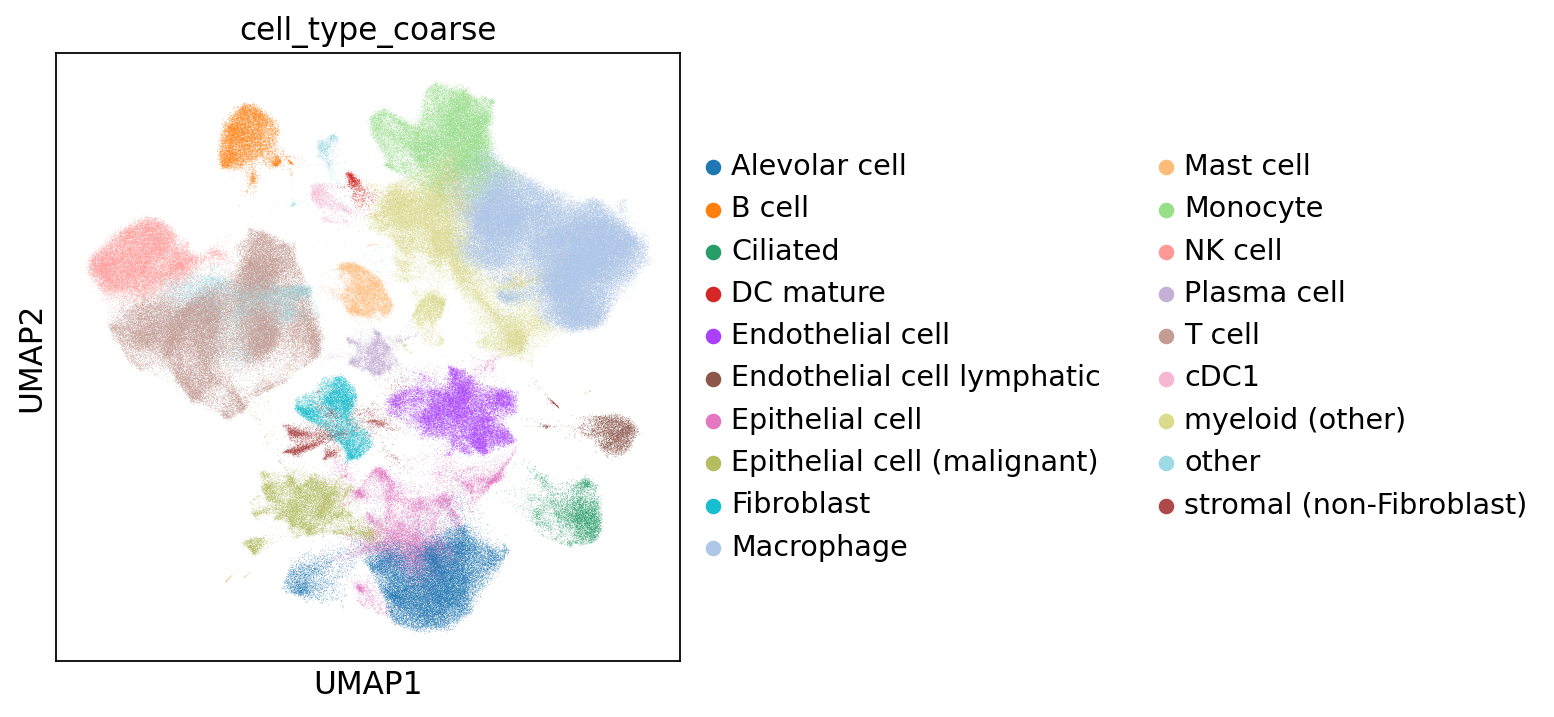

In [10]:
sc.pl.umap(adata, color="cell_type_coarse")

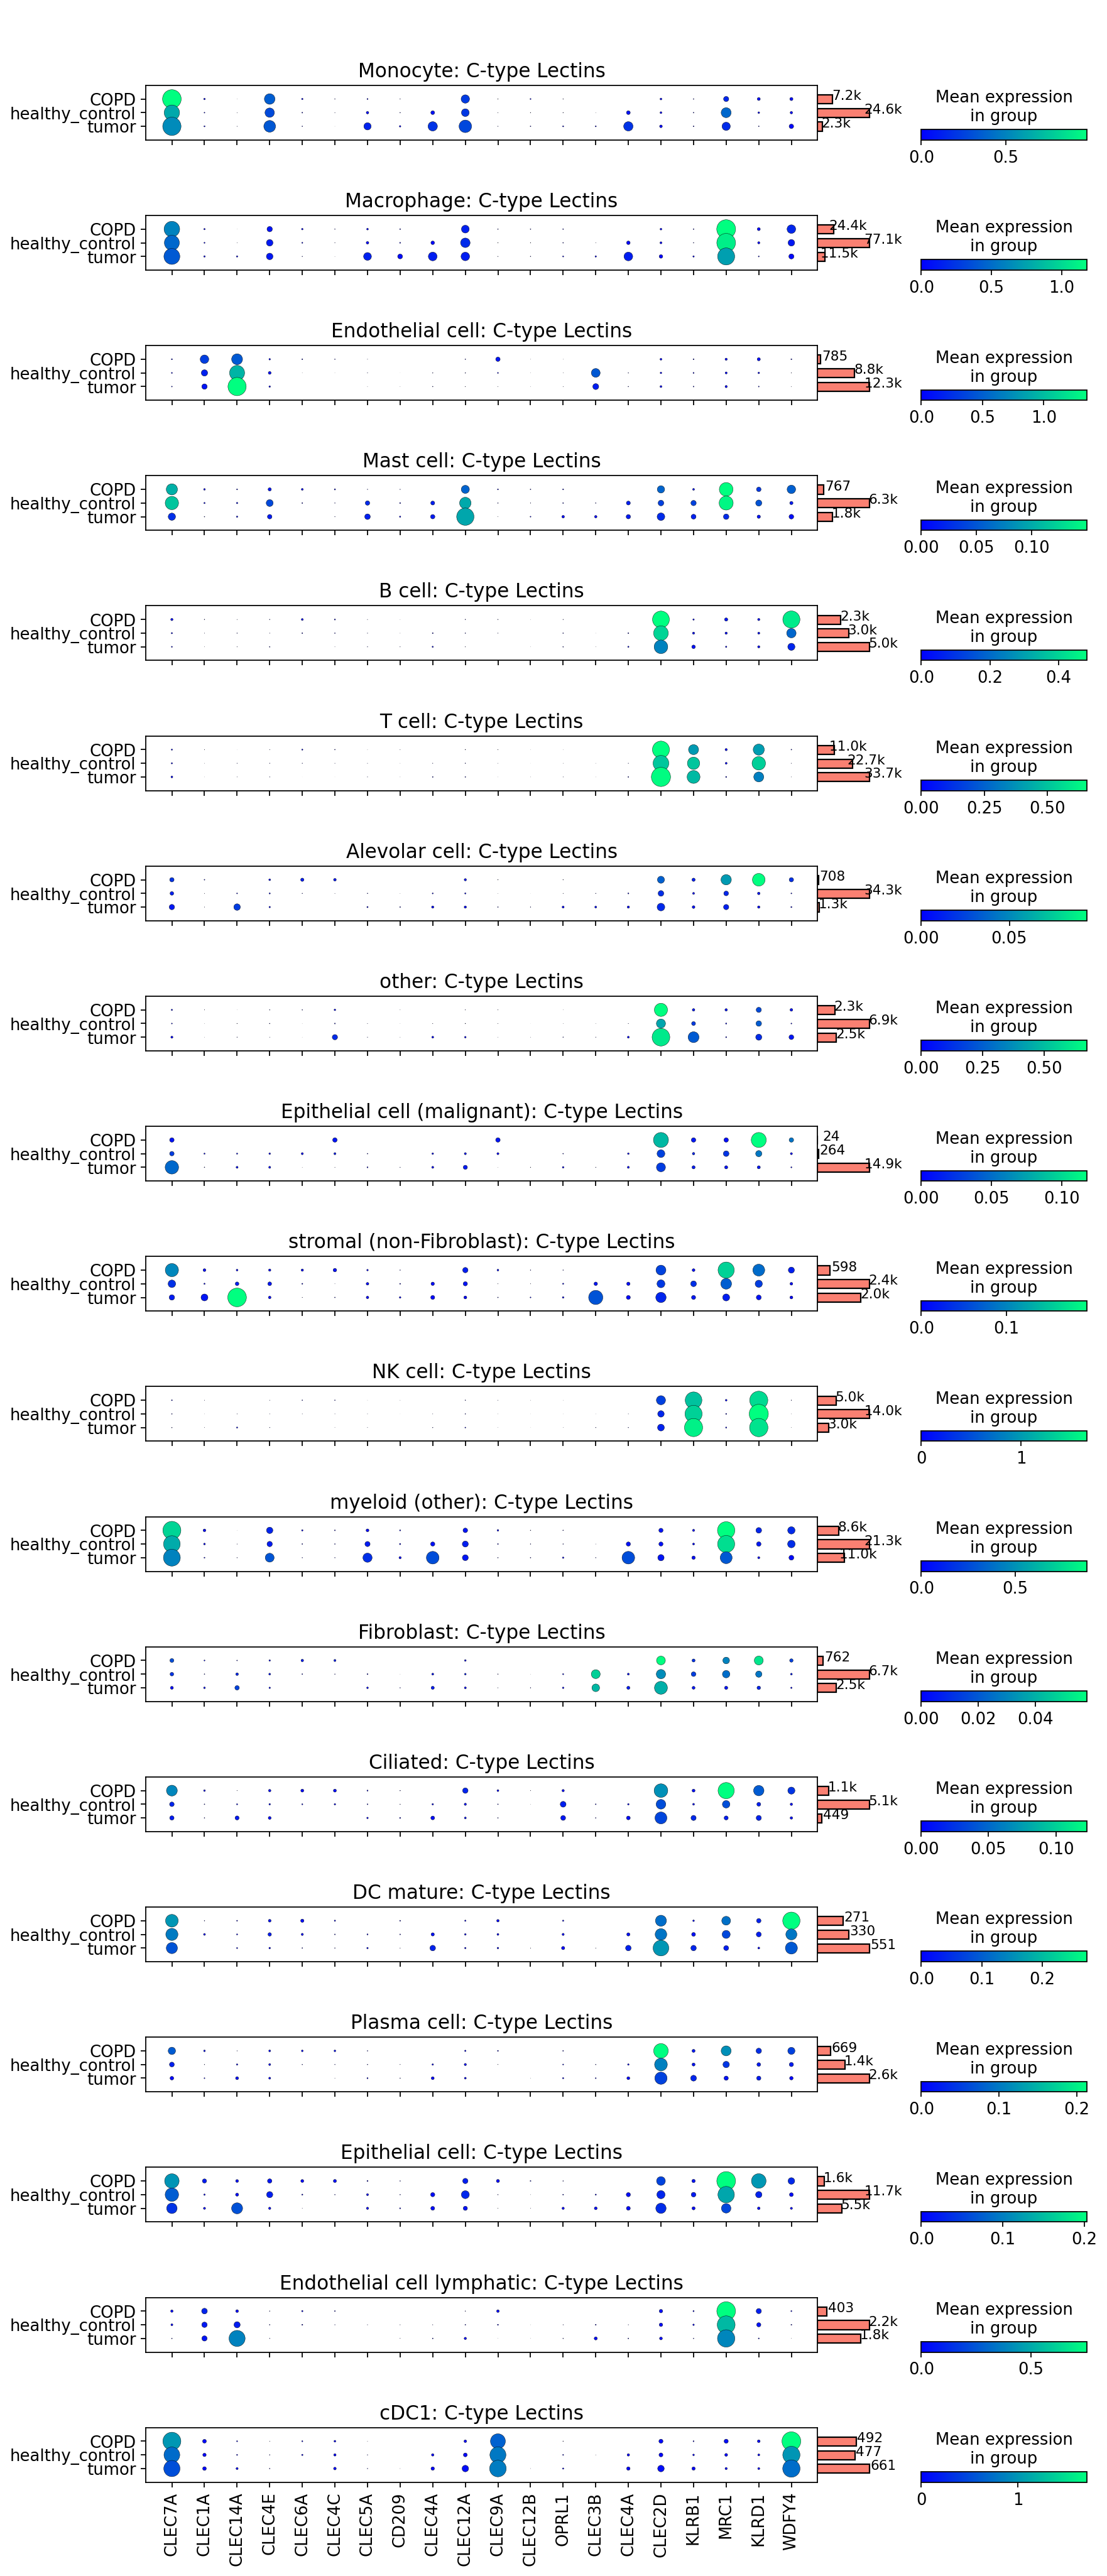

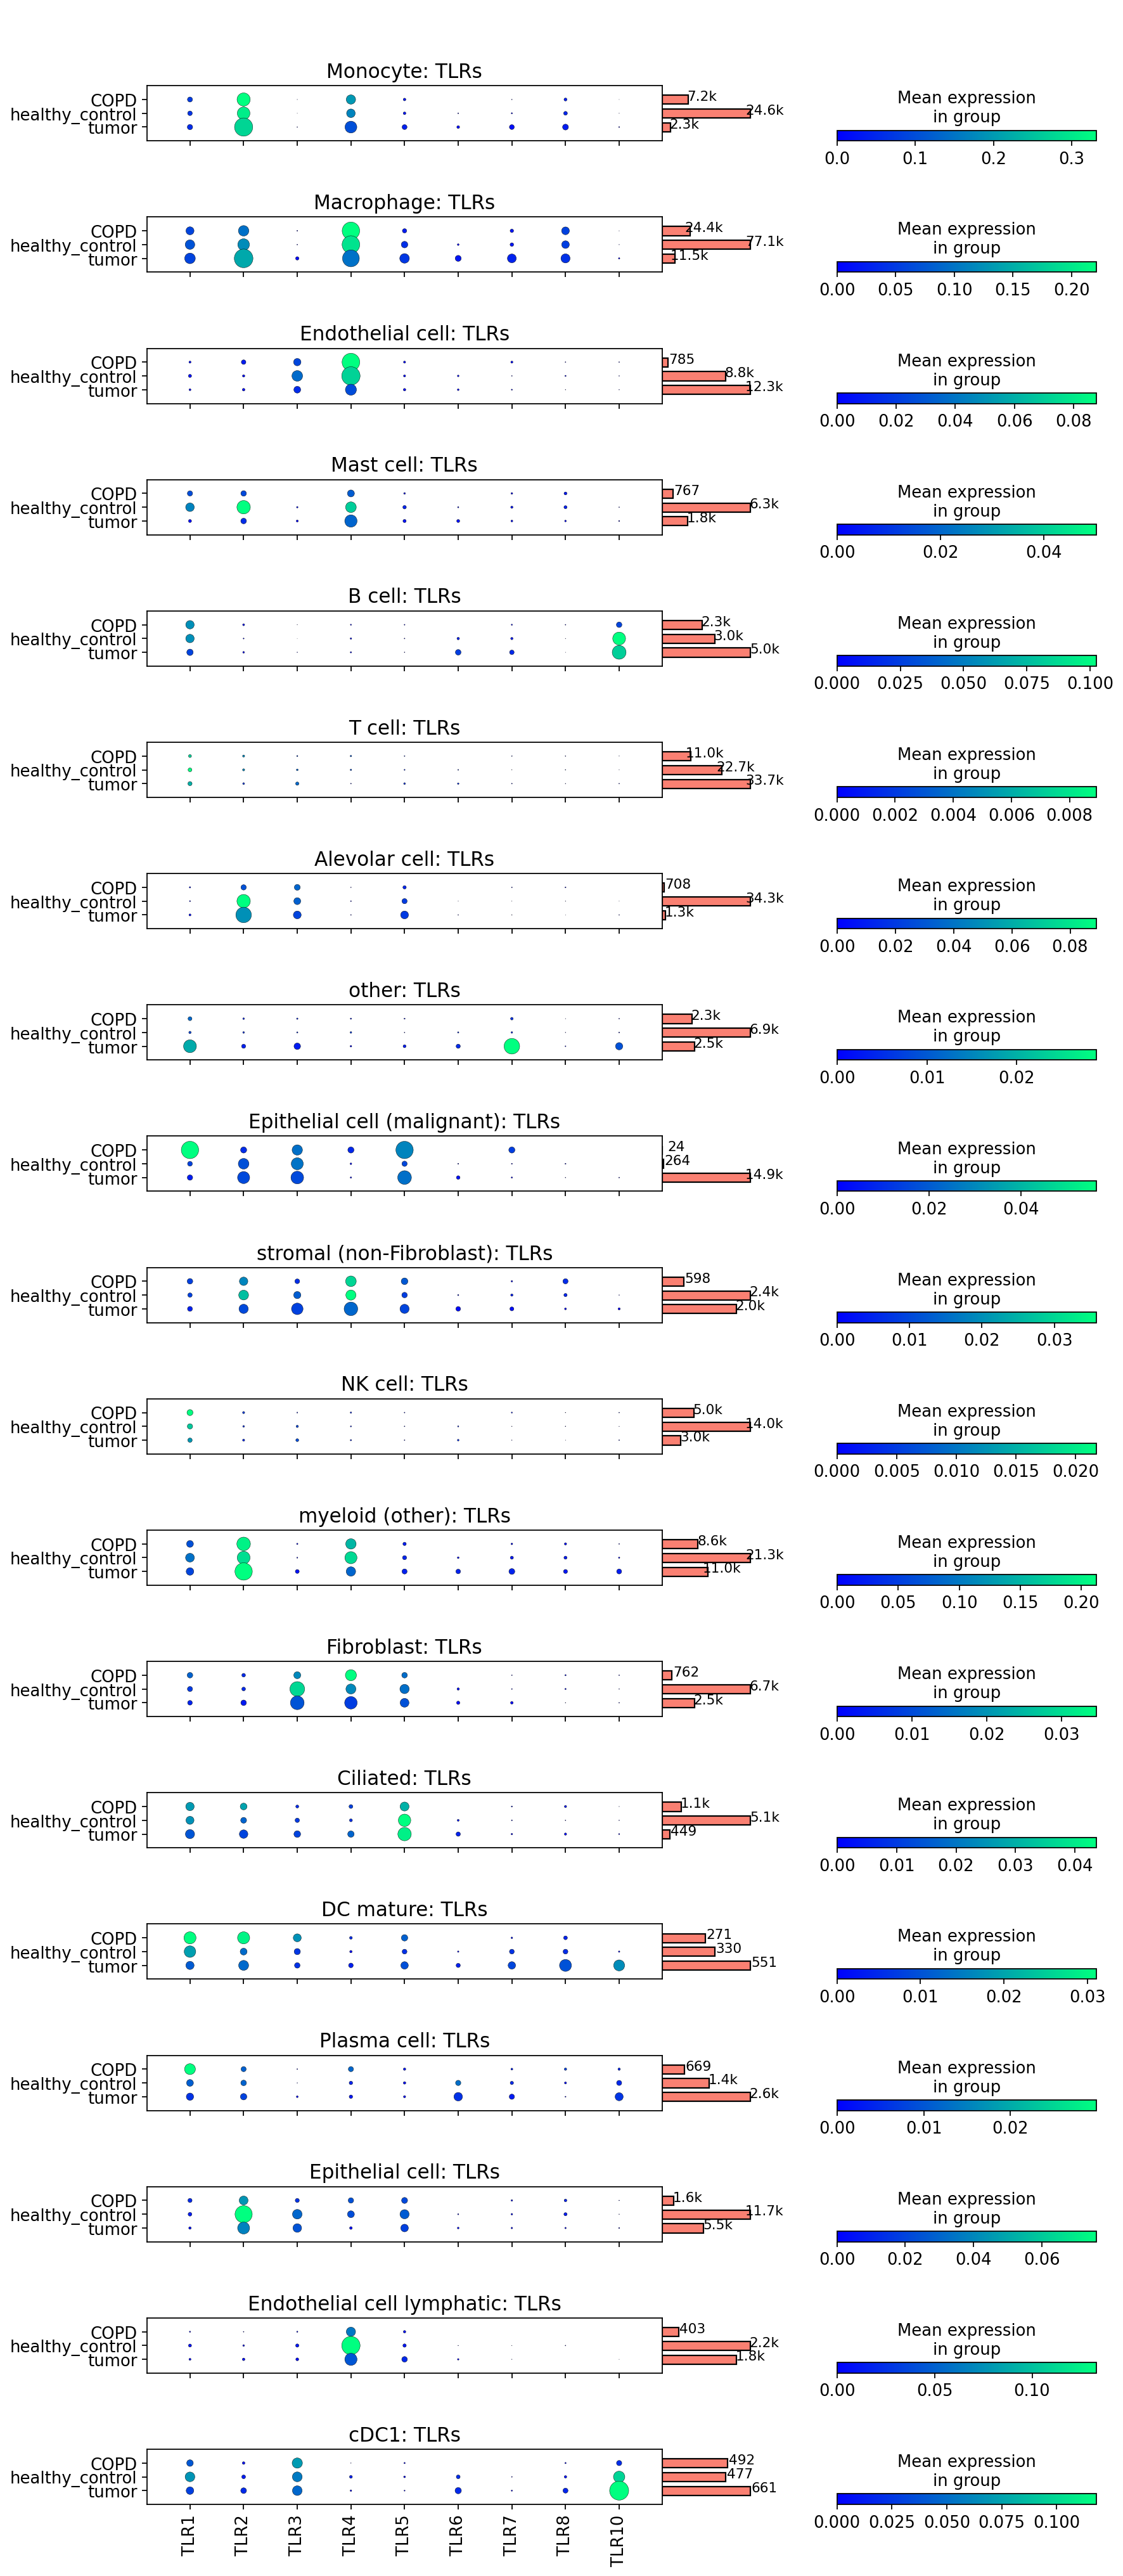

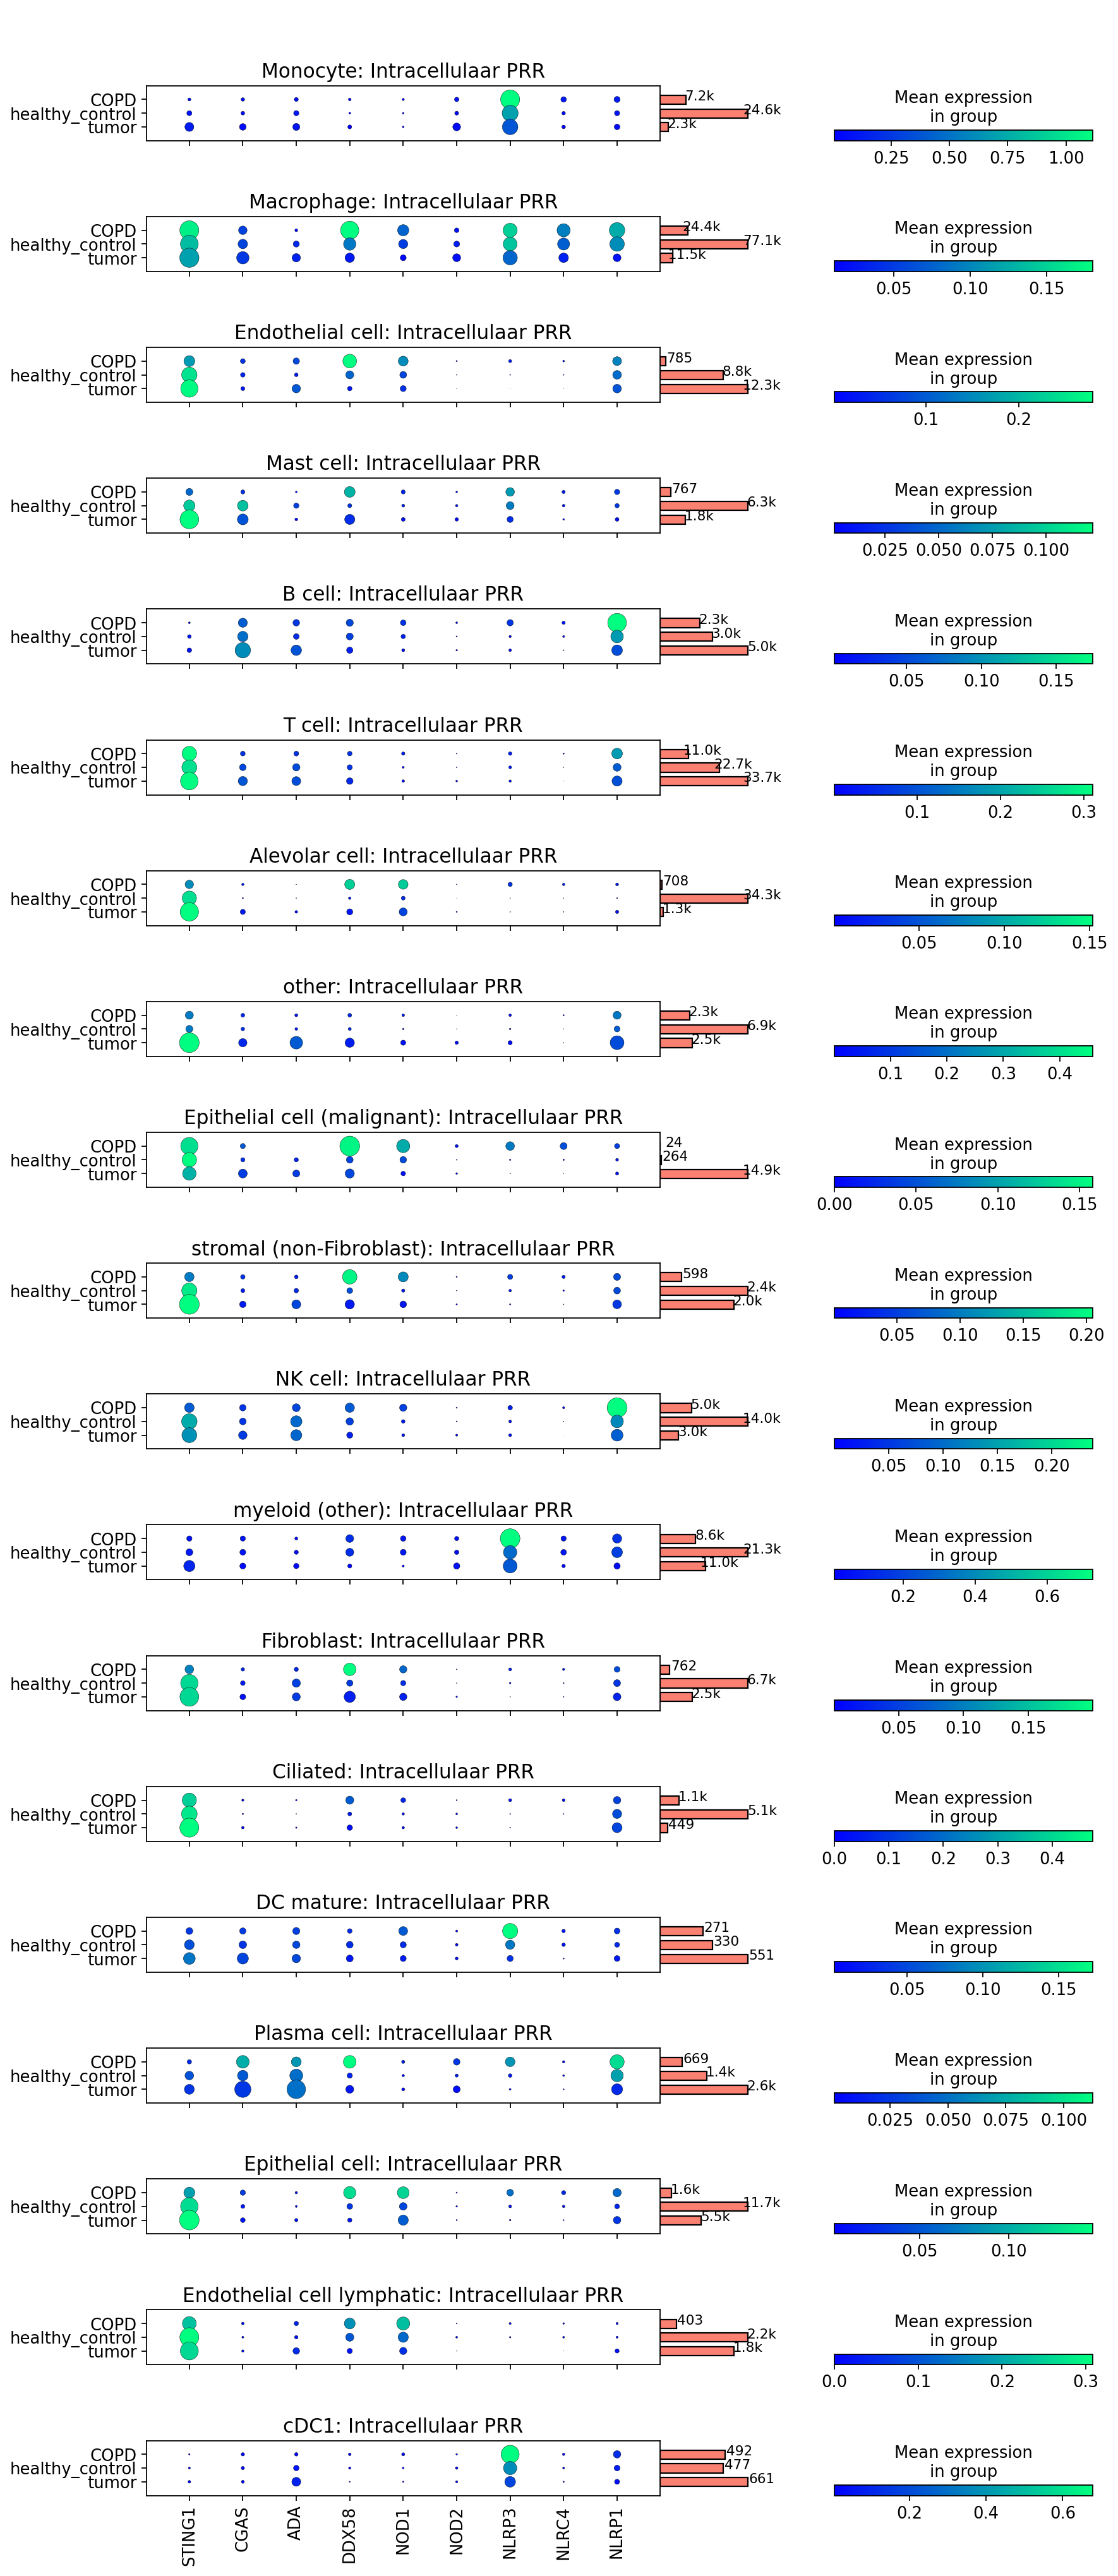

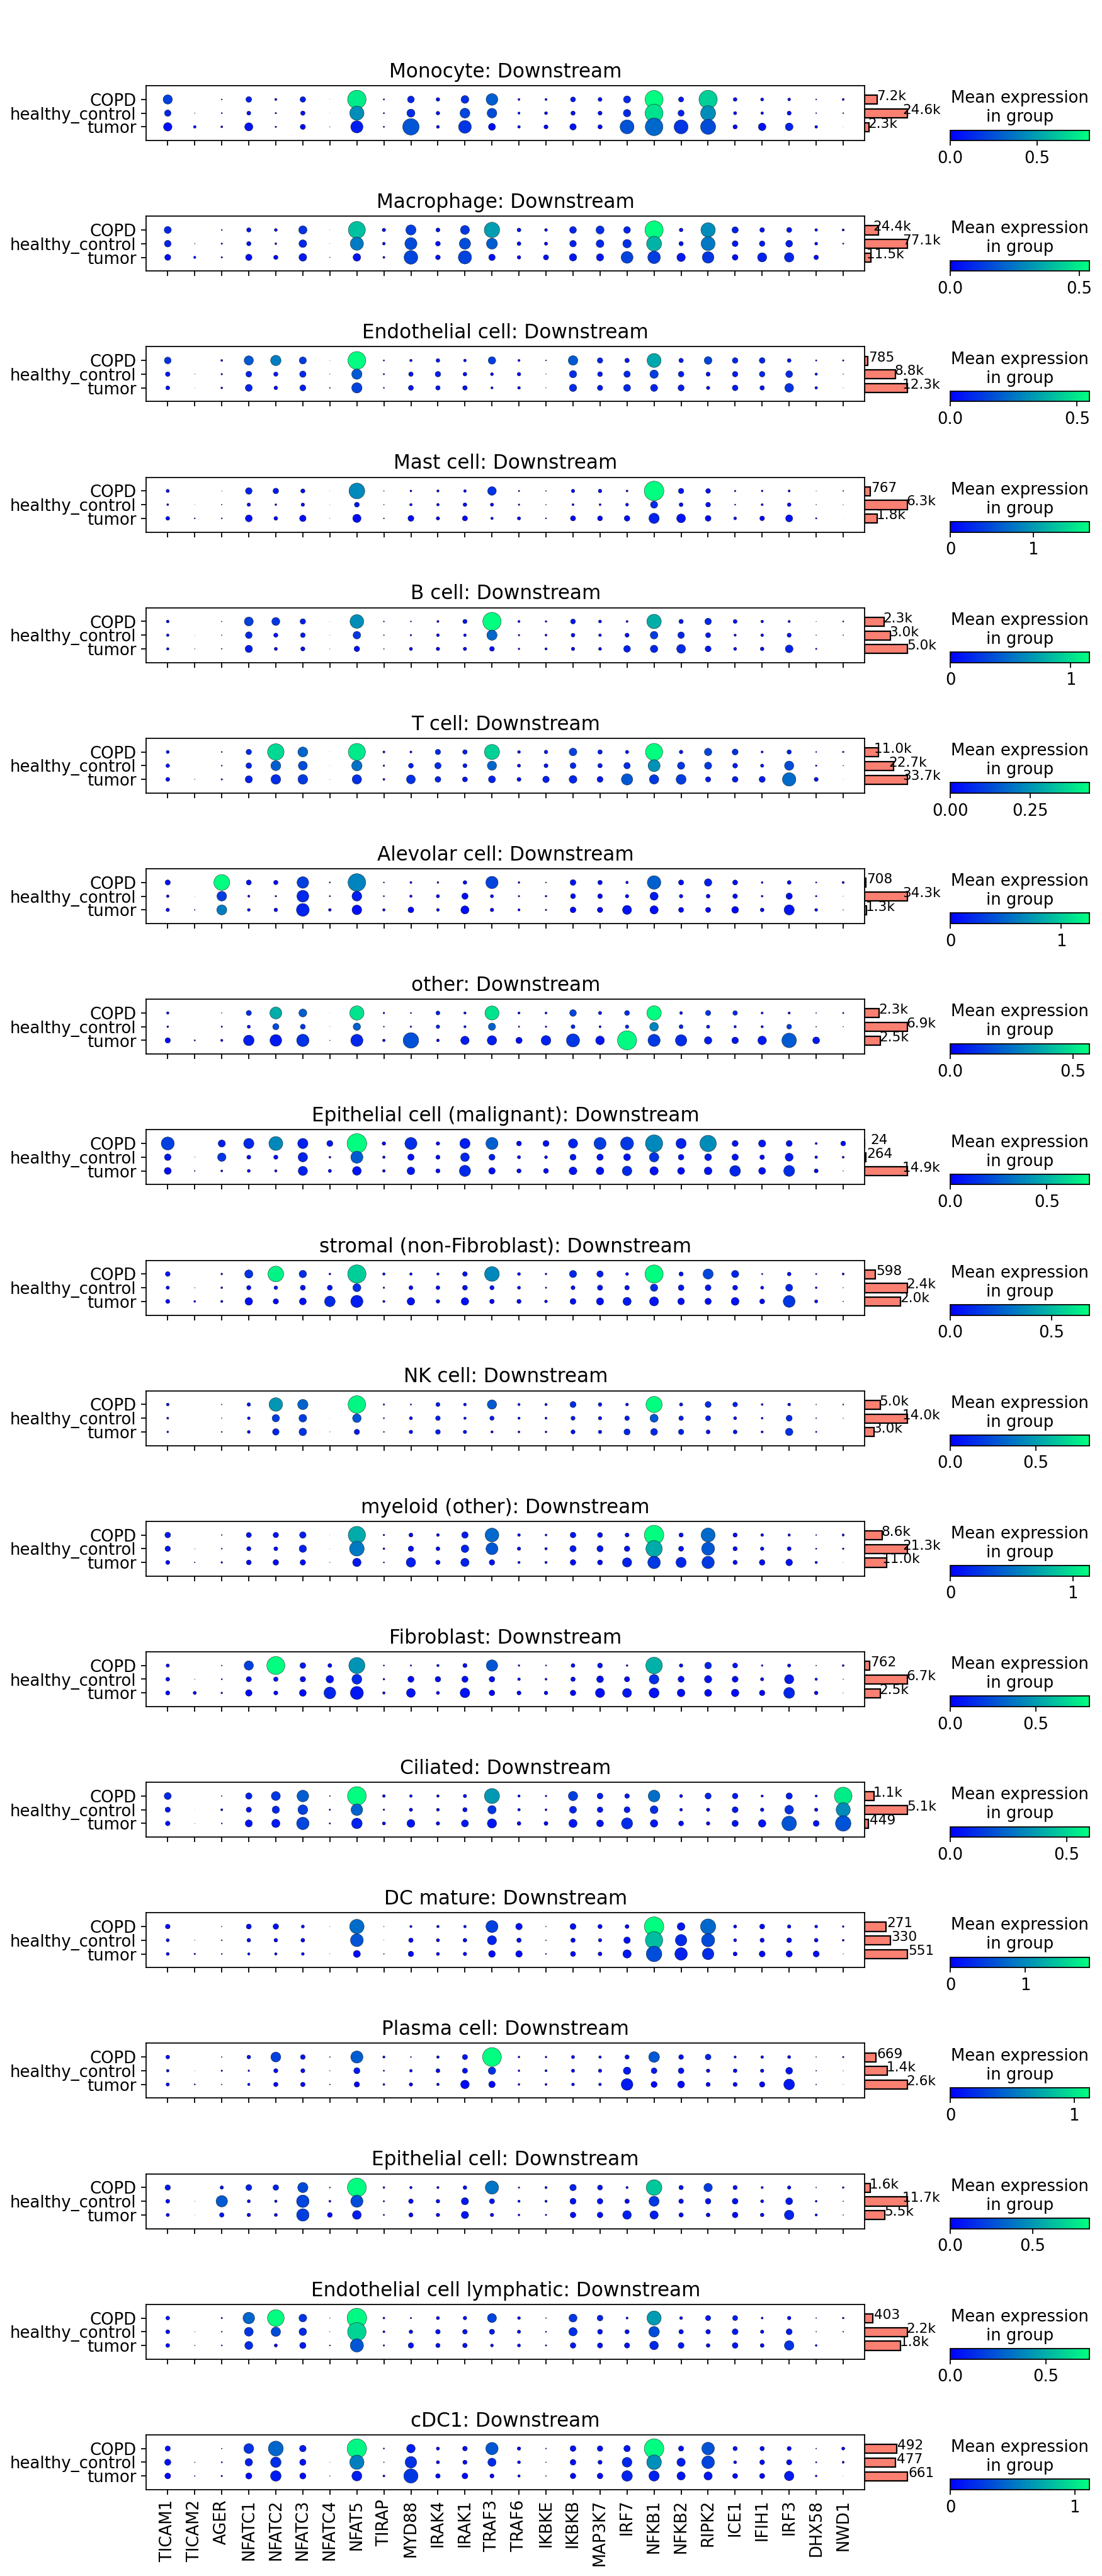

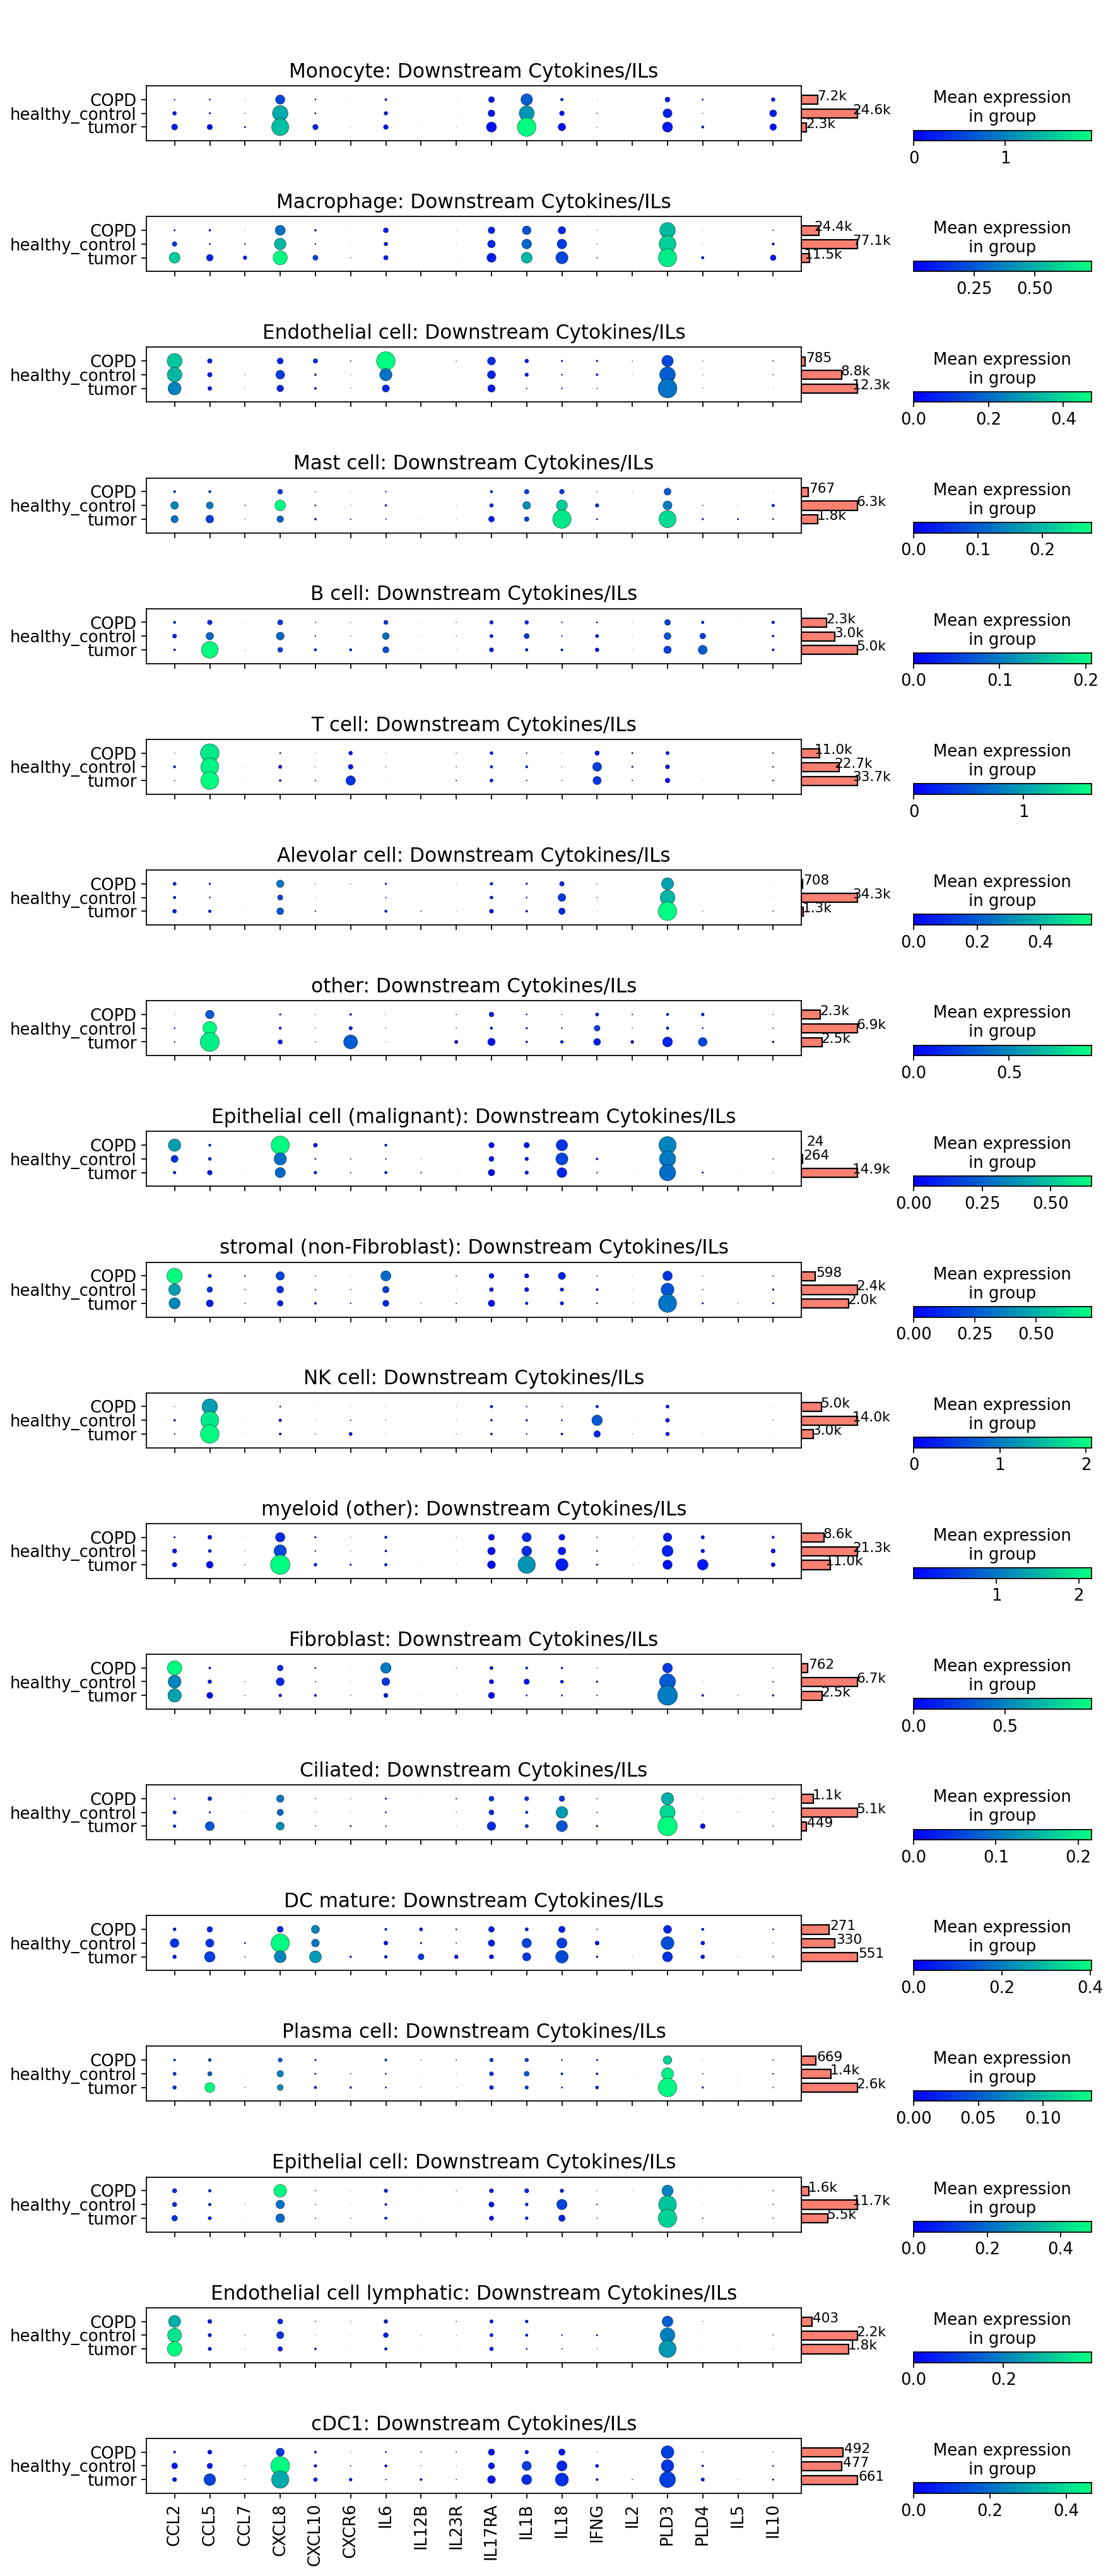

In [11]:
cell_types = adata.obs["cell_type_coarse"].unique()
for label, genes in gene_sets.items():
    filename = re.sub("[^0-9a-zA-Z]+", "_", label.lower())
    fig, axs = plt.subplots(len(cell_types), 1, figsize=(12, 60))
    for i, (cell_type, ax) in enumerate(zip(cell_types, axs)):
        dp = sc.pl.DotPlot(
            adata[adata.obs["cell_type_coarse"] == cell_type, :],
            groupby="disease_state",
            var_names=genes,
            ax=ax,
        )
        dp.add_totals()
        dp.legend(width=2, show_size_legend=False)
        tmp_axs = dp.get_axes()
        if i != len(cell_types) - 1:
            tmp_axs["mainplot_ax"].set_xticklabels([])
        tmp_axs["mainplot_ax"].set_title(f"{cell_type}: {label}")
    plt.subplots_adjust(bottom=0.5, wspace=-1, hspace=0)
    fig.savefig(f"figures/dotplot_{filename}.pdf", bbox_inches="tight")

## Compare Epithelial cells and malignant epithelial cells

### Prepare annotation

In [12]:
adata_epi = adata[adata.obs["cell_type_coarse"].str.startswith("Epi"), :]
# exclude the handful of cells from healthy/COPD that got misannotated as malignant
adata_epi = adata_epi[
    ~(
        (adata_epi.obs["cell_type_coarse"] == "Epithelial cell (malignant)")
        & (adata_epi.obs["disease_state"].isin(["healthy_control", "COPD"]))
    ),
    :,
]
adata_api = adata_epi.copy()

In [13]:
adata_epi.obs["cell_type_coarse"].unique()

['Epithelial cell (malignant)', 'Epithelial cell']
Categories (2, object): ['Epithelial cell (malignant)', 'Epithelial cell']

In [14]:
adata_epi.obs["annotation"] = [
    f"{ct} ({condition})"
    for ct, condition in zip(
        adata_epi.obs["cell_type_coarse"], adata_epi.obs["disease_state"]
    )
]

Trying to set attribute `.obs` of view, copying.


In [15]:
patient_count = Counter(adata_epi[adata_epi.obs["annotation"] == "Epithelial cell (malignant) (tumor)", :].obs["patient"])
annotation_by_patient = []
for annot, patient in zip(adata_epi.obs["annotation"], adata_epi.obs["patient"]):
    if annot == "Epithelial cell (malignant) (tumor)":
        if patient_count[patient] >= 100:
            annotation_by_patient.append(f"{annot} [{patient}]")
        else:
            annotation_by_patient.append(f"{annot} [other patient]")
    else:
        annotation_by_patient.append(annot)
        
adata_epi.obs["annotation_by_patient"] = annotation_by_patient

... storing 'annotation' as categorical
... storing 'annotation_by_patient' as categorical


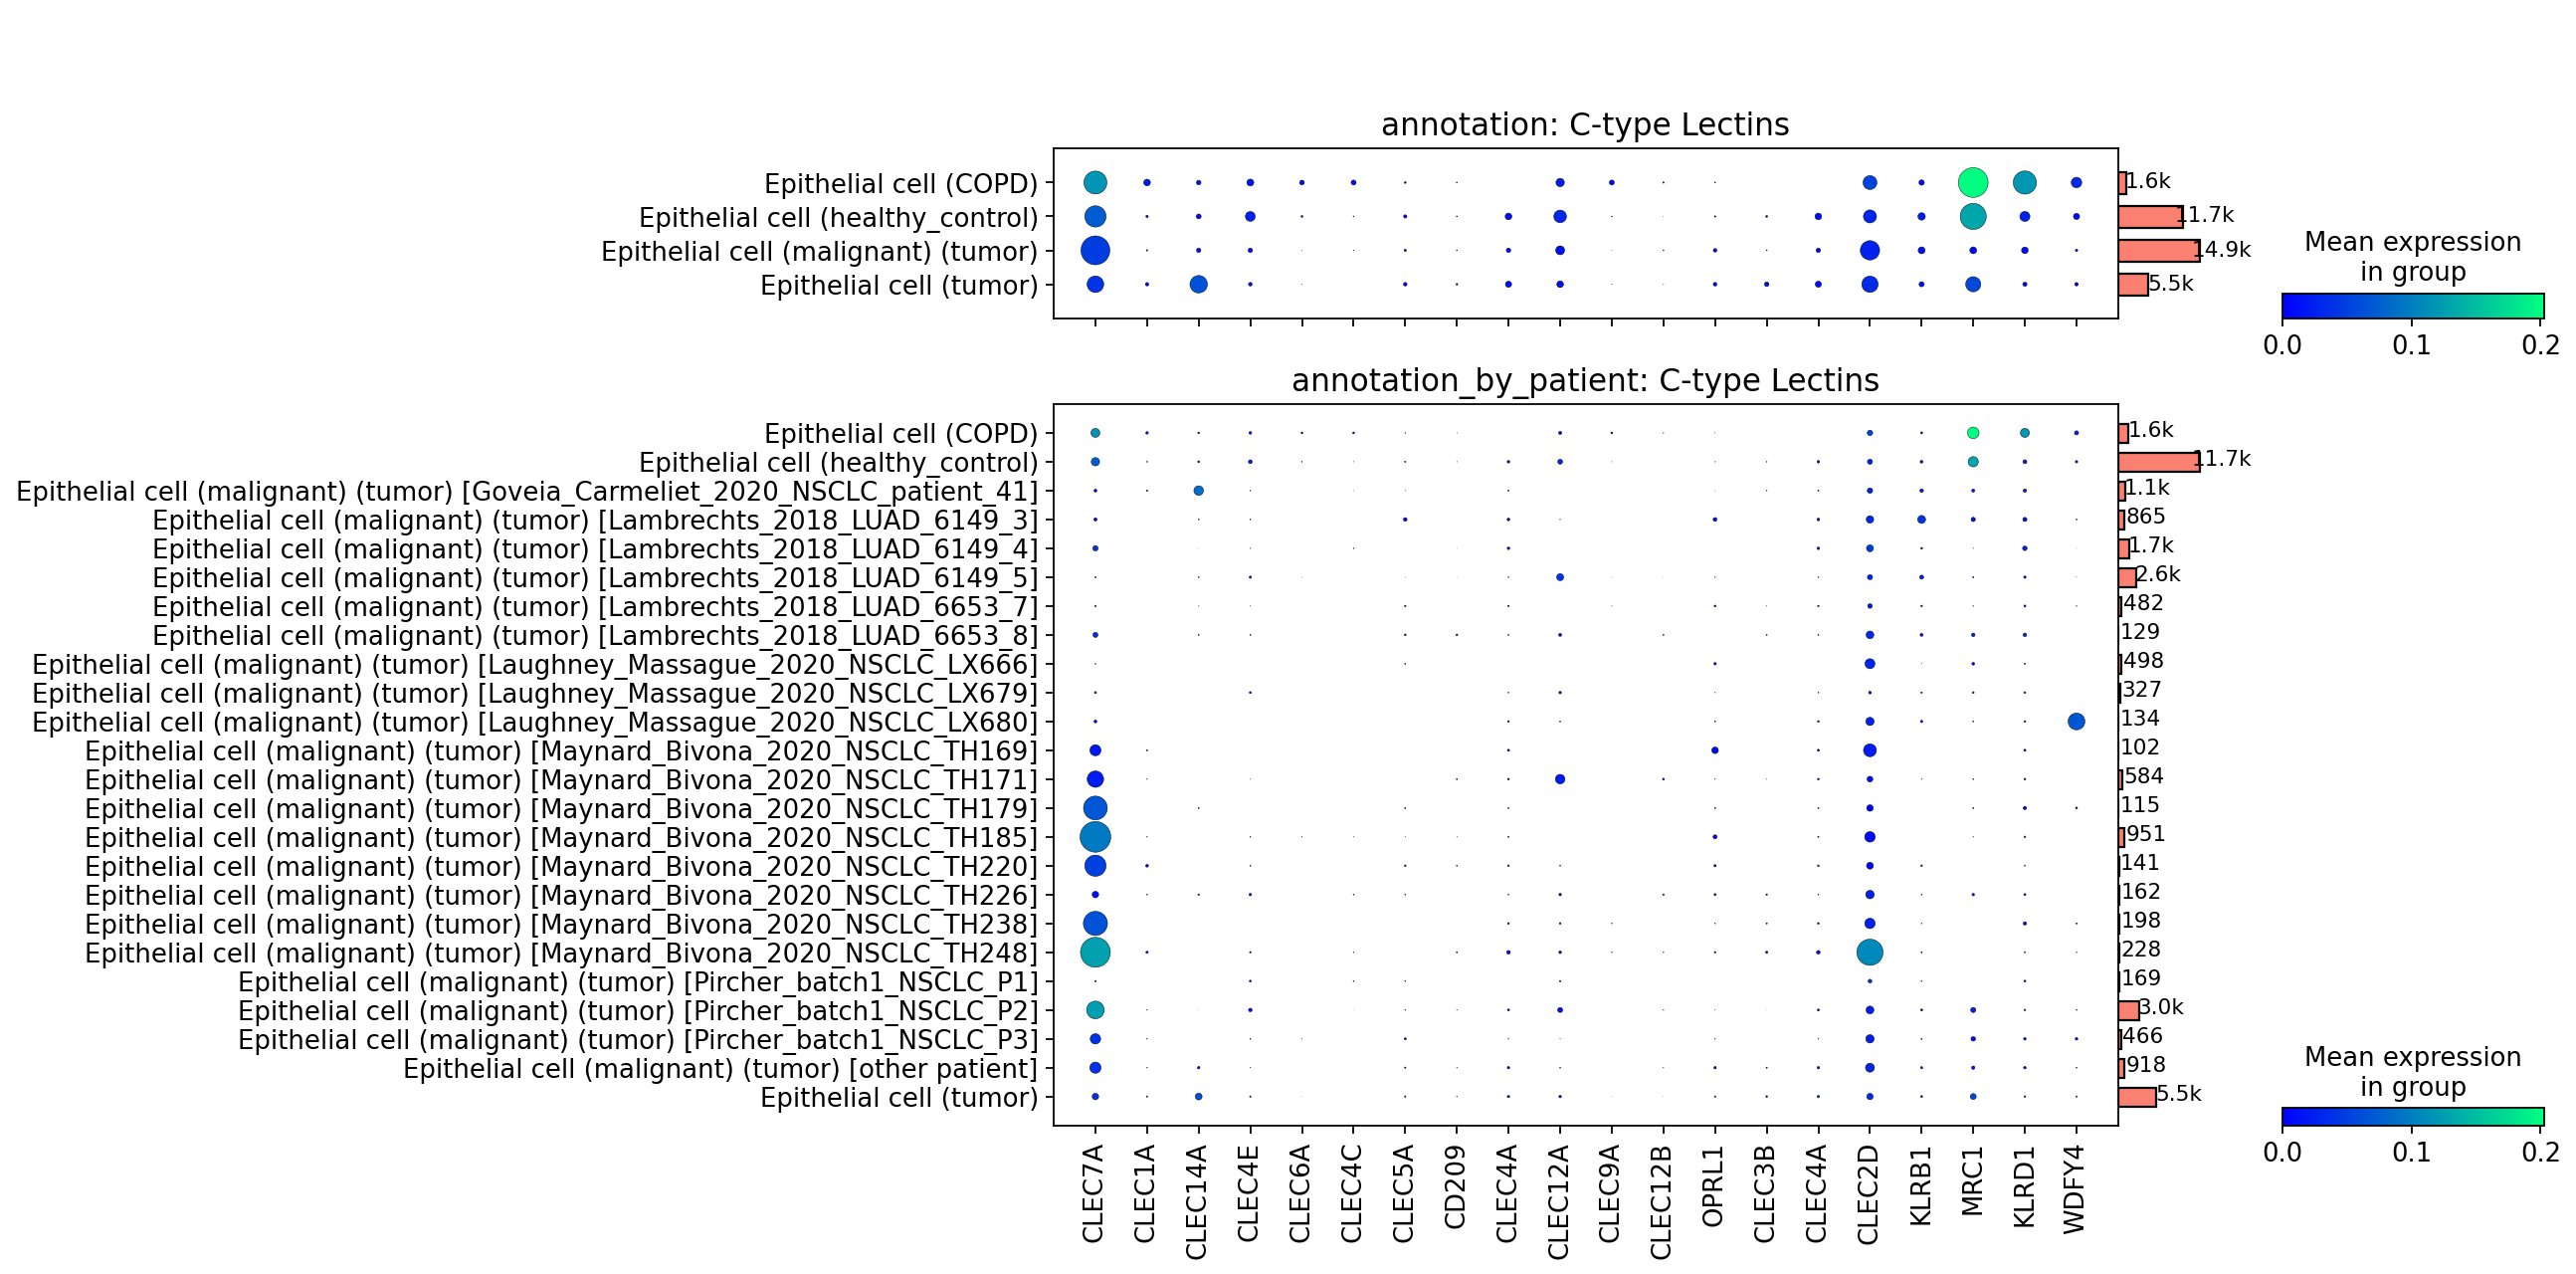

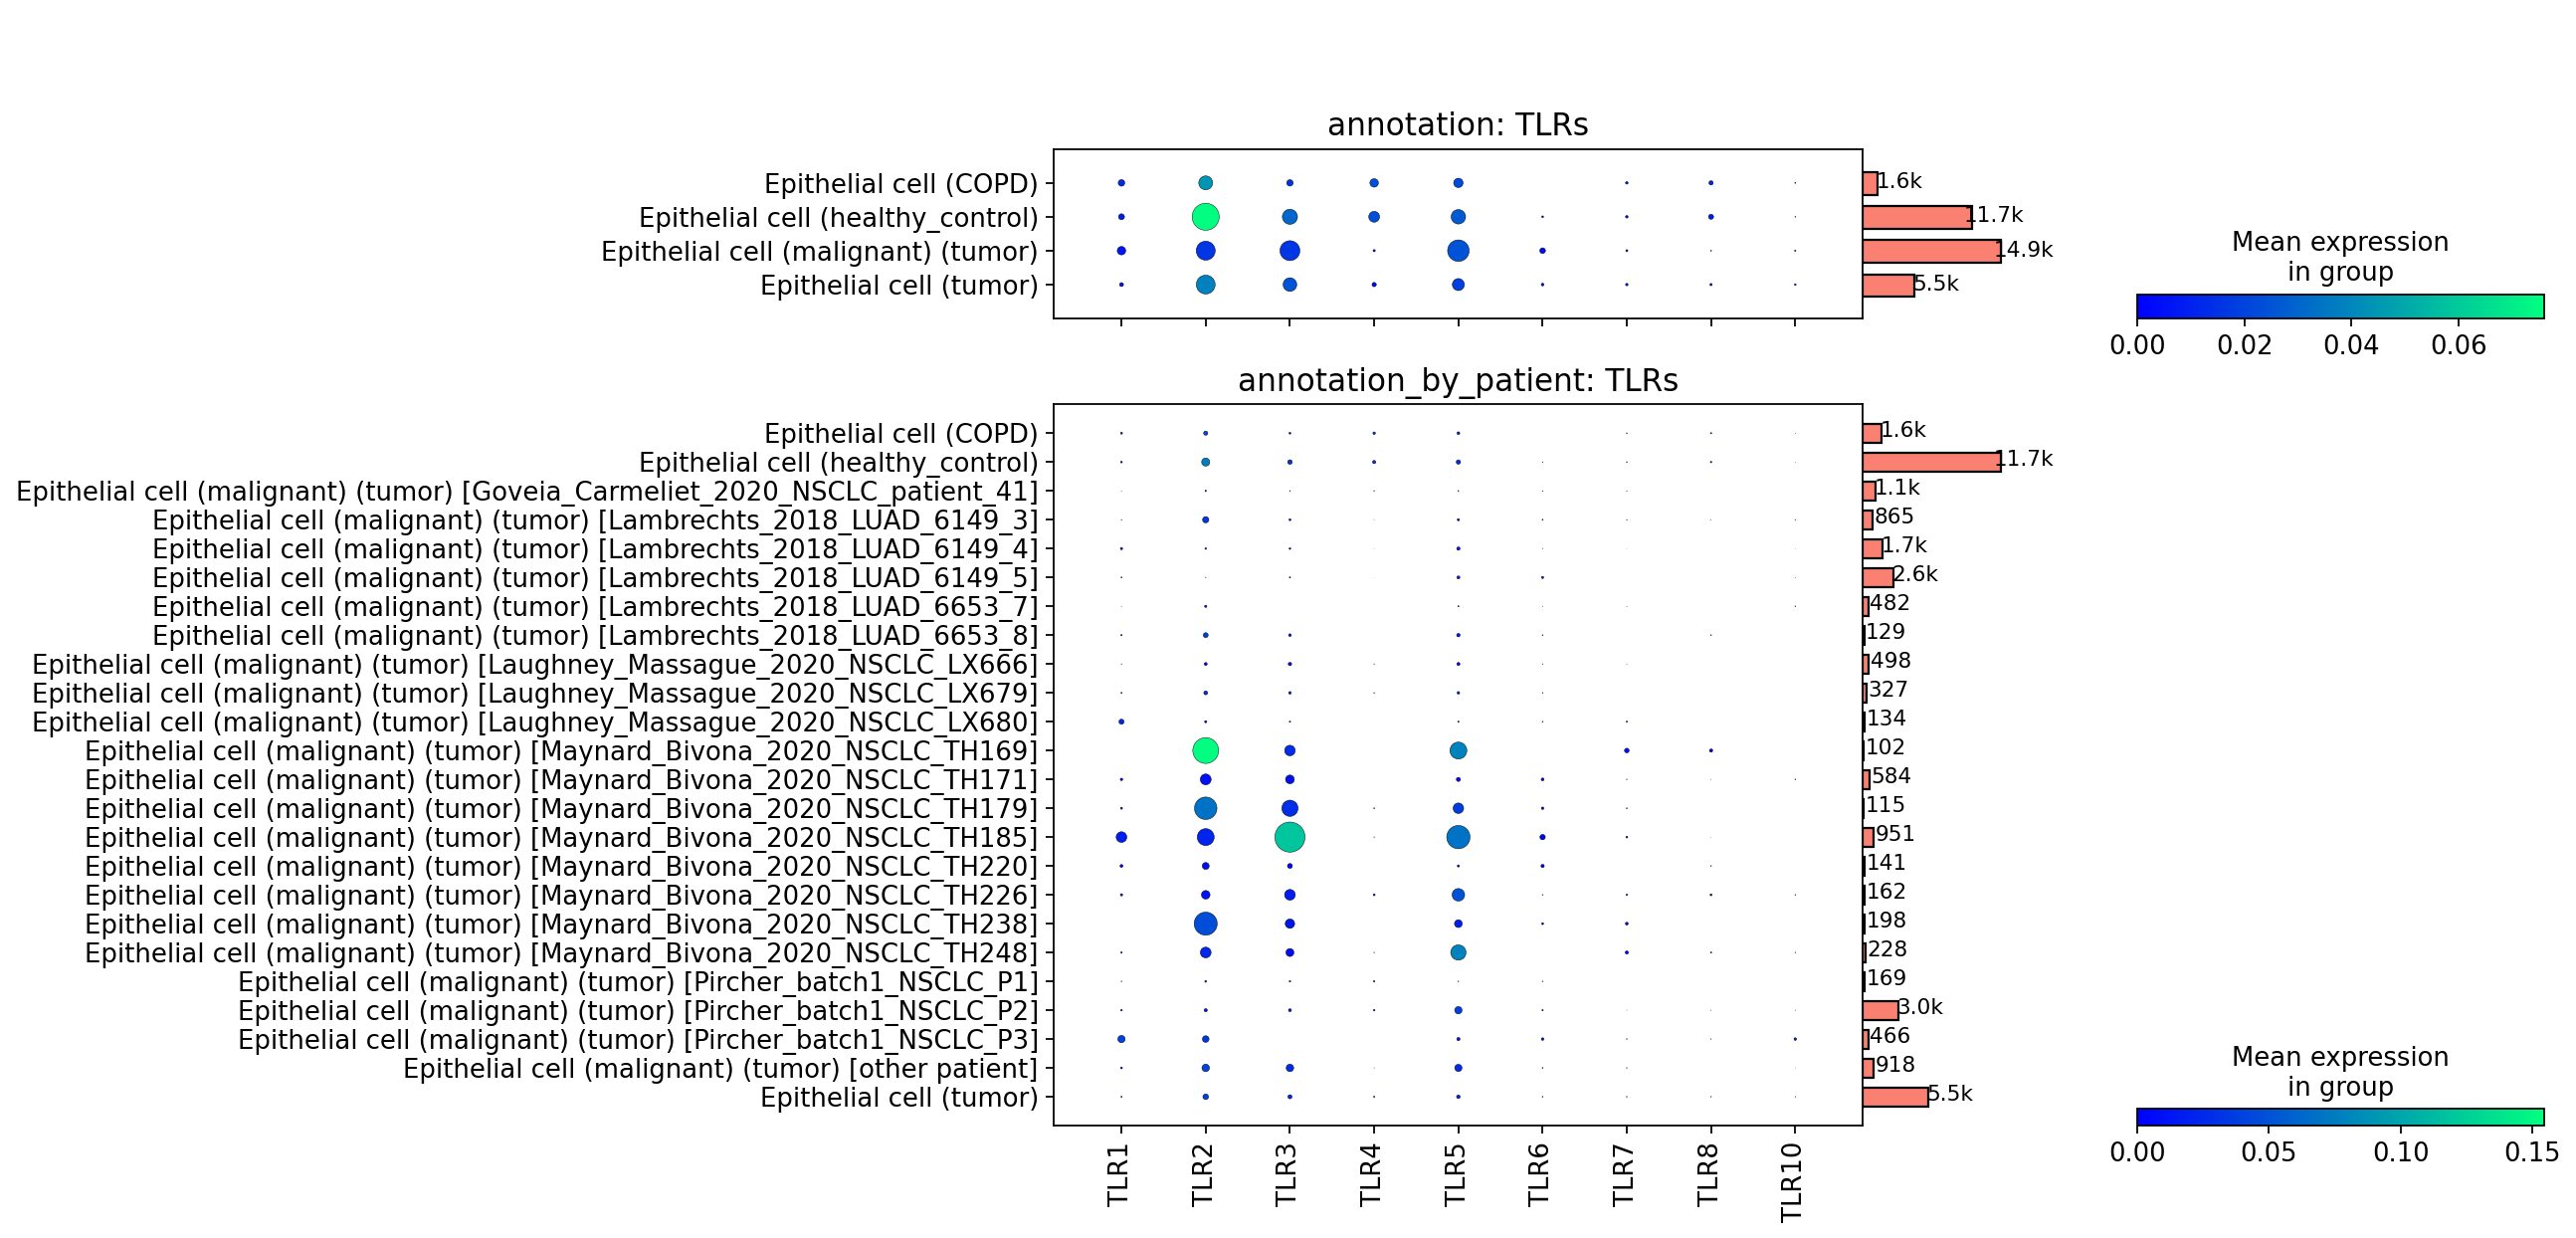

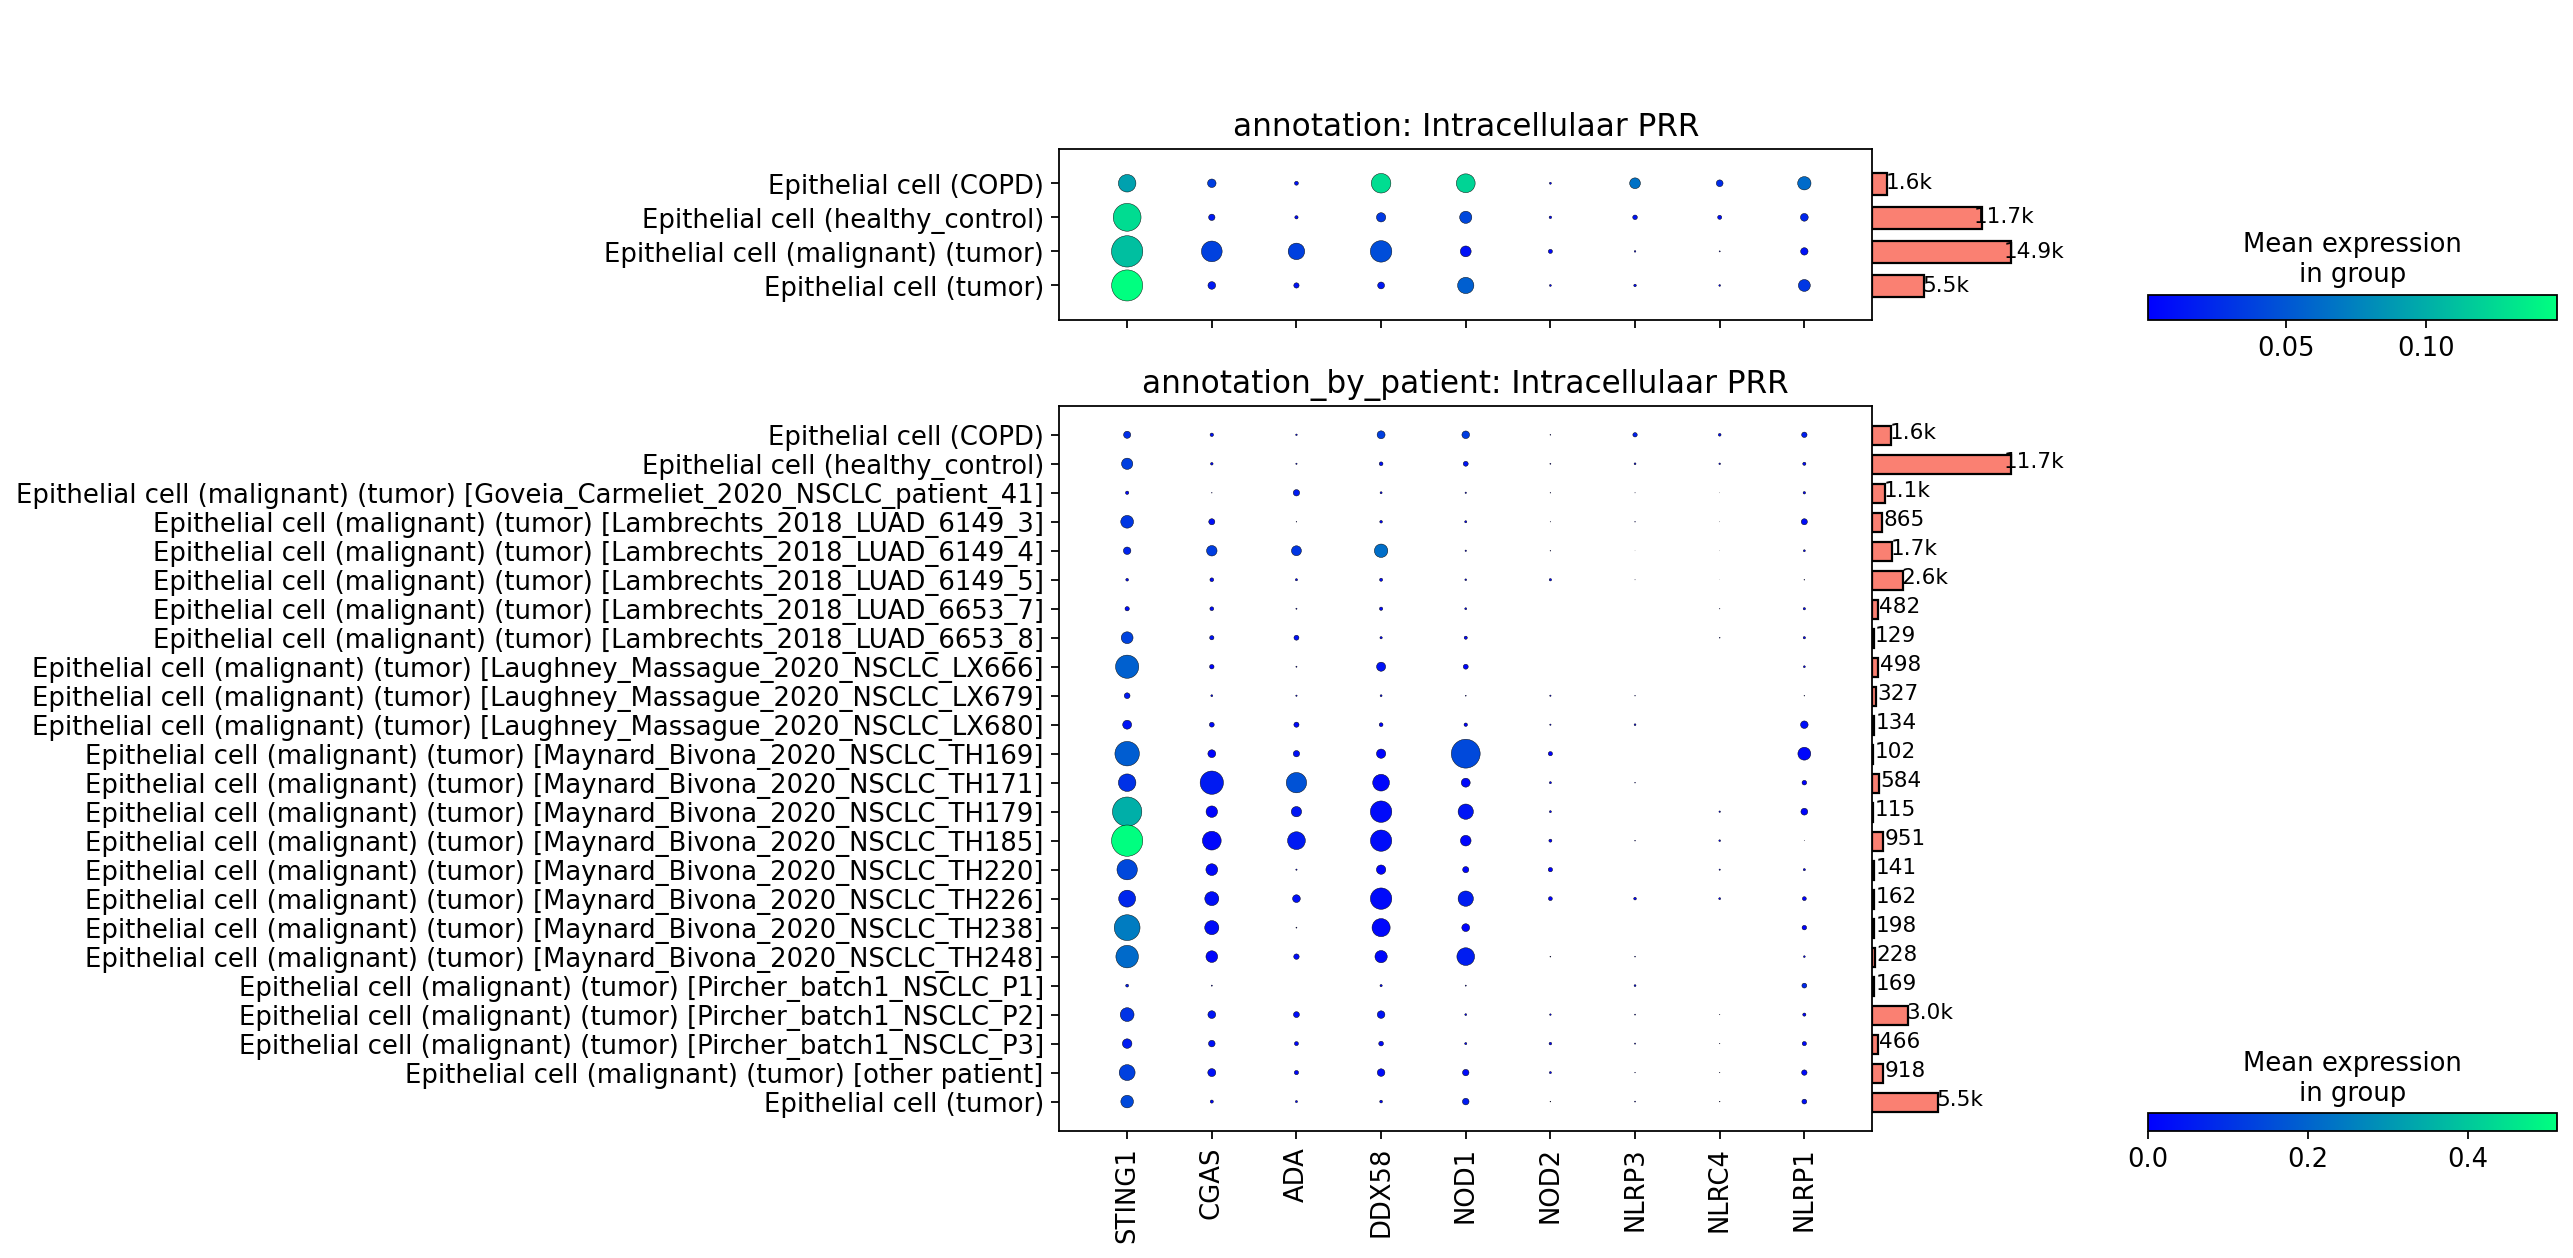

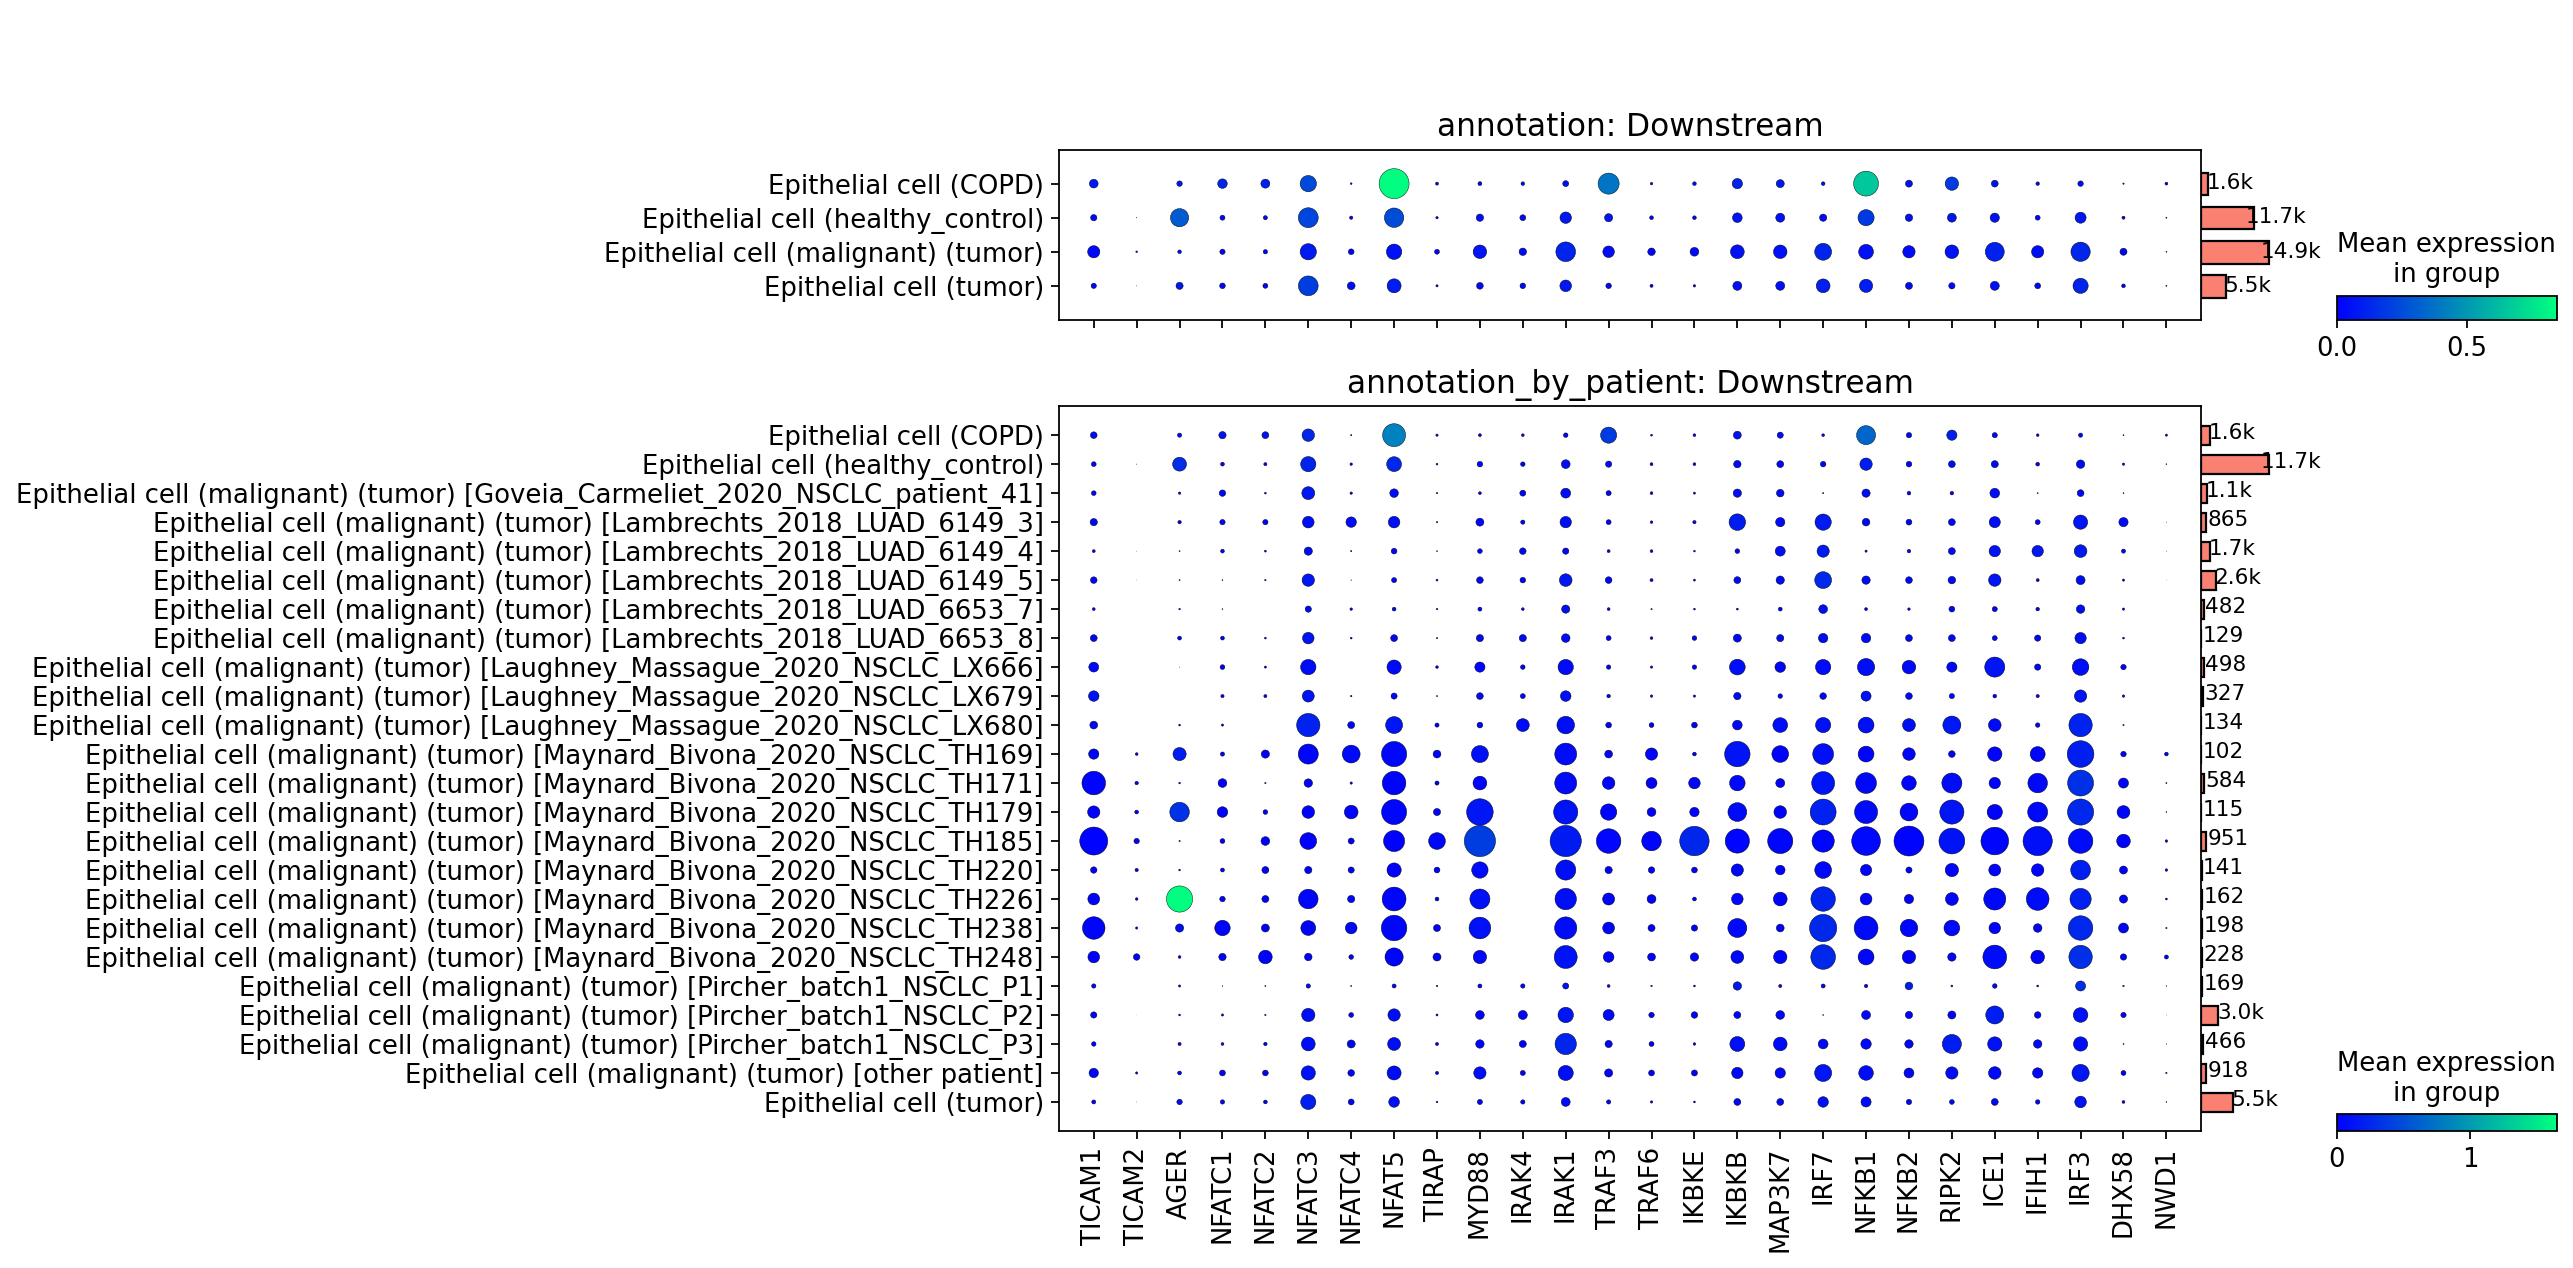

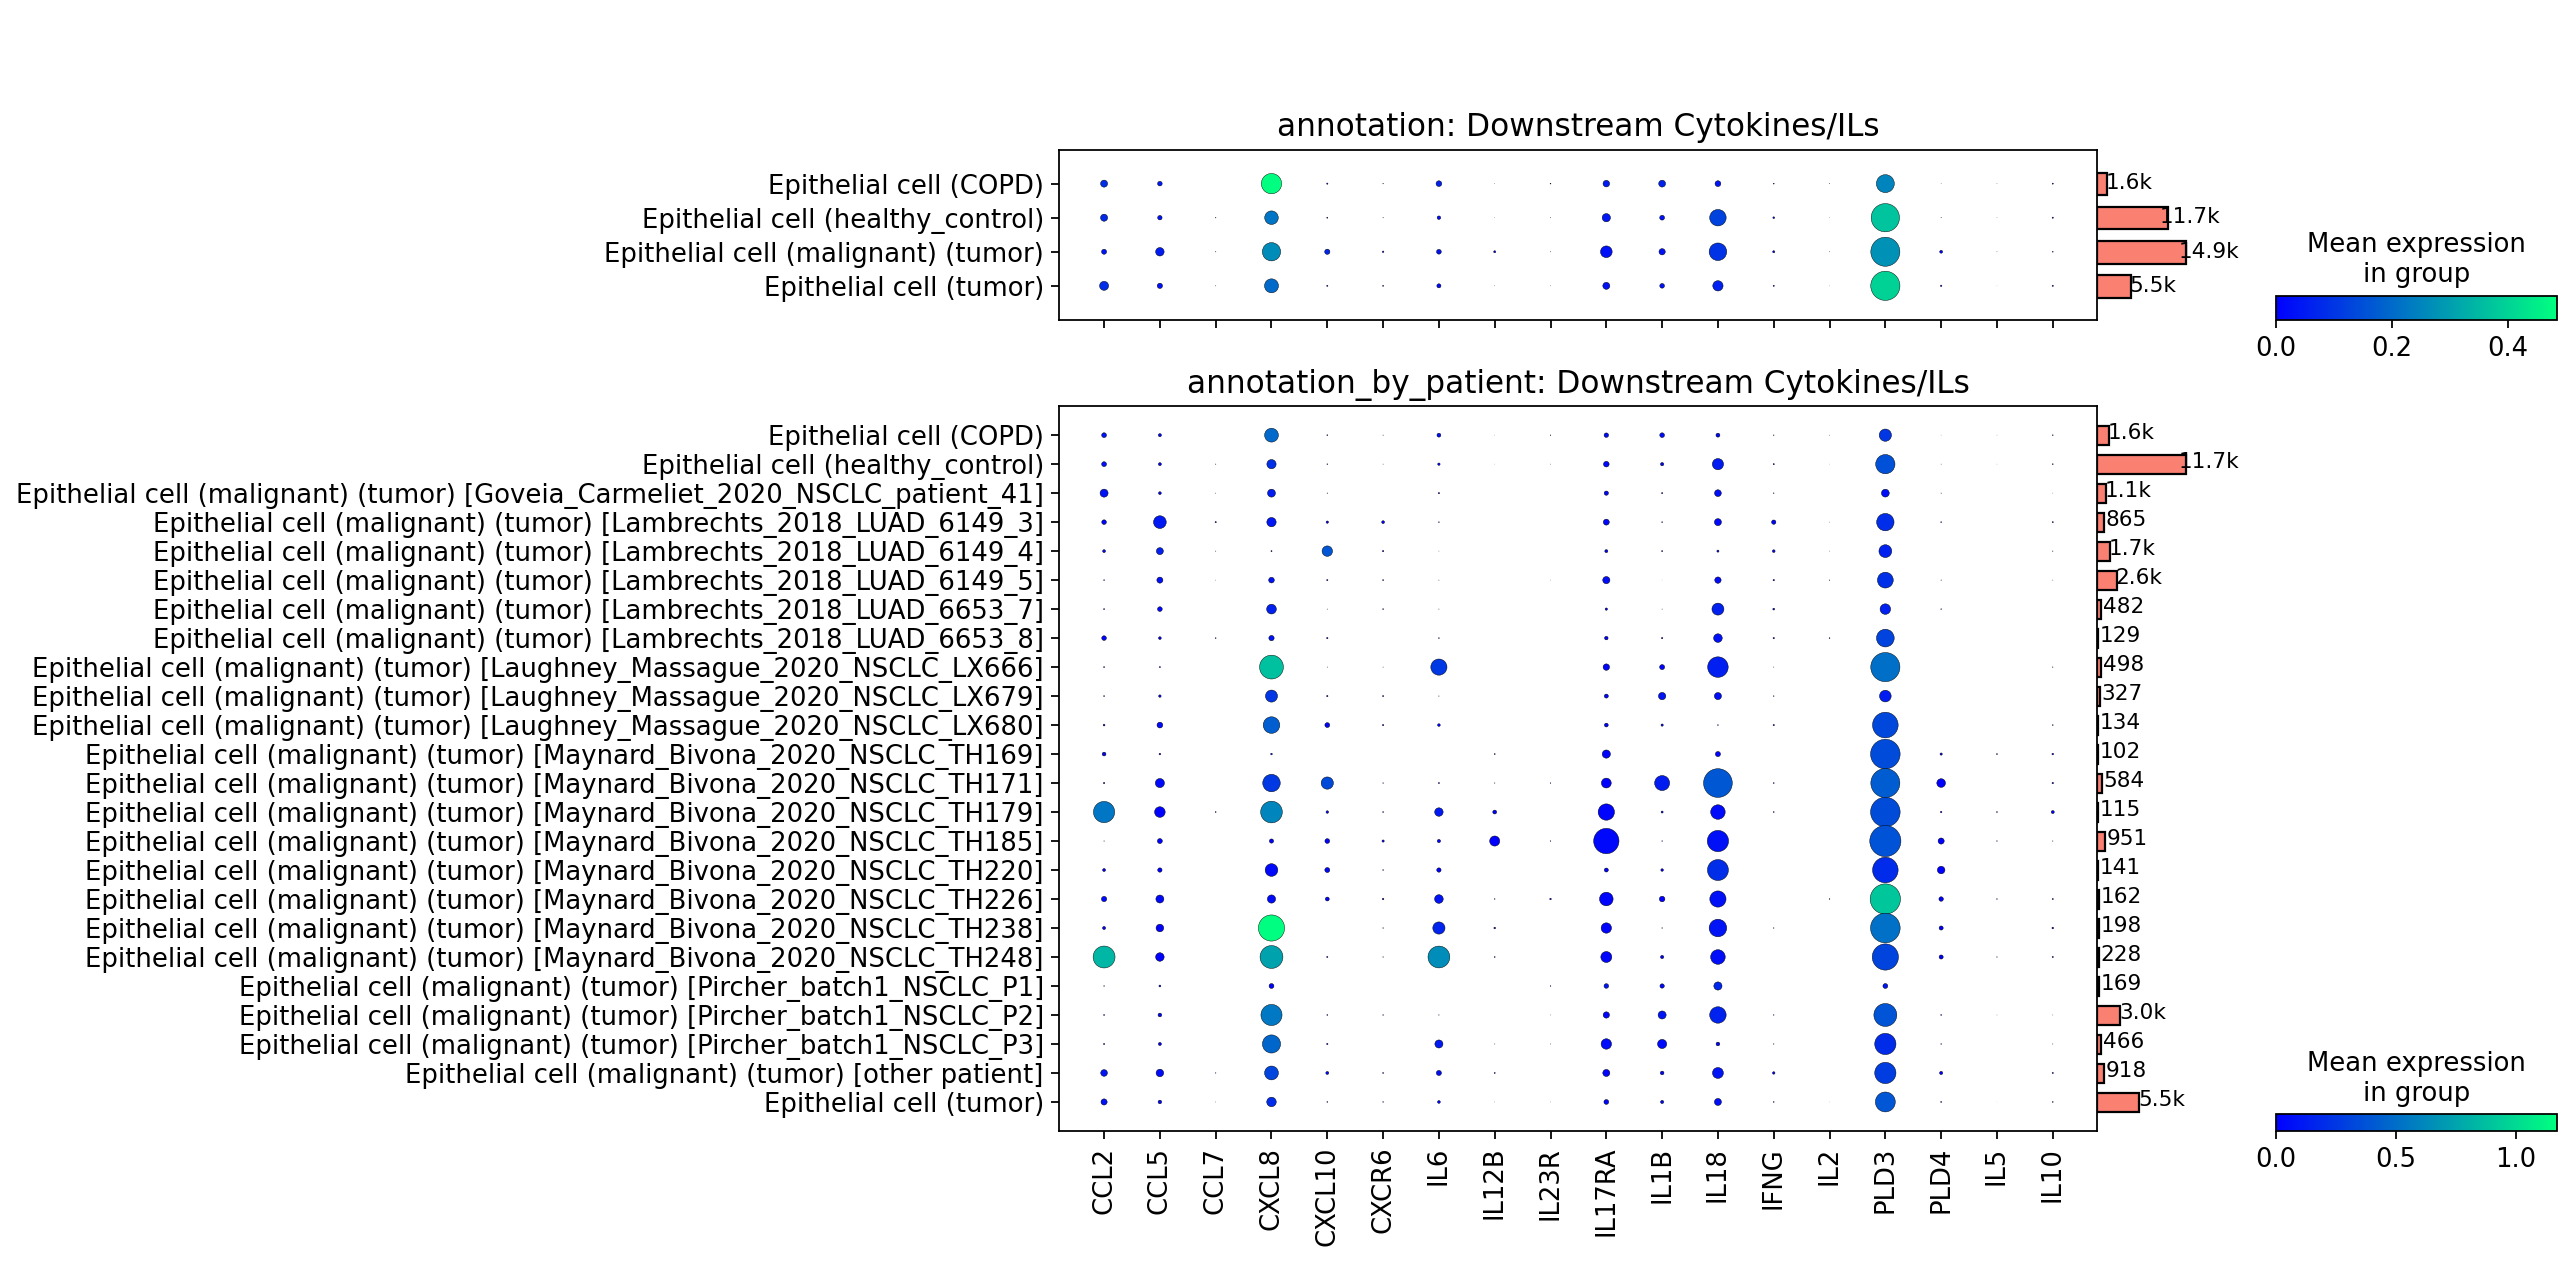

In [16]:
for label, genes in gene_sets.items():
    filename = re.sub("[^0-9a-zA-Z]+", "_", label.lower())
    fig, axs = plt.subplots(2, 1, figsize=(12, 17), gridspec_kw={"height_ratios": [.3,.8]})
    for i, (cat, ax) in enumerate(zip(["annotation", "annotation_by_patient"], axs)):
        dp = sc.pl.DotPlot(
            adata_epi,
            groupby=cat,
            var_names=genes,
            ax=ax,
        )
        dp.add_totals()
        dp.legend(width=2, show_size_legend=False)
        tmp_axs = dp.get_axes()
        if i ==0:
            tmp_axs["mainplot_ax"].set_xticklabels([])
        tmp_axs["mainplot_ax"].set_title(f"{cat}: {label}")
    plt.subplots_adjust(bottom=0.5, wspace=-1, hspace=0)
    fig.savefig(f"figures/dotplot_epi_{filename}.pdf", bbox_inches="tight")    